In [43]:
import pandas as pd
from collections import defaultdict
import nltk
from nltk import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/sofia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv("../data/interim/dataset.csv")

In [4]:
data.head()

,Unnamed: 0,manually_assigned_tag,url,content
0,0,supermarket,https://www.walmart.com.ar,nueva nueva correctamente puede cerrar lacteos...
1,0,supermarket,https://www.makro.com.ar,logo entra cuenta quiero fornecedor sobre quie...
2,0,supermarket,https://www.alvearsupermercados.com.ar/,alvearsupermercados logo blanco alvearsupermer...
3,0,supermarket,https://www.yaguar.com.ar/,supermercado blanca chaco cordoba cordoba cont...
4,0,supermarket,https://www.libertadsa.com.ar/,logo separador cordoba separador separador sep...


In [7]:
data = data.drop(columns=['Unnamed: 0'])

In [8]:
data.columns

Index(['manually_assigned_tag', 'url', 'content'], dtype='object')

In [88]:
class Stemmer(): # naive class
    def __init__(self):
        self.stems = list()
        self.stemmed_freqs = defaultdict(list)
        self.tokens = list()

    def tokenize(self, document):
        if not isinstance(document, list):
            if isinstance(document, str):
                self.tokens = document.split(' ')
            else:
                raise TypeError('str or dict expected, {} found.'.format(type(document)))
        else:
            self.tokens = document        

        spanishstemmer = SnowballStemmer('spanish')
        self.stems = [spanishstemmer.stem(token) for token in self.tokens]
    
    def get_stemming_mapList(self): #1
        mapping = list()
        for idx, word in enumerate(self.tokens):
            mapping.append((self.stems[idx], word))
        return mapping
    
    def stemmed_frequencies(self, stemms_mapList, reverse=True): #2 Sorted from max to min by default
        stemmed_freqs = defaultdict(list)
        ffreqs = dict()
        for tuple_ in stemms_mapList:
            stemmed_freqs[tuple_[0]].append(tuple_[1])        
        
        for elem in stemmed_freqs.items():
            stemm = elem[0]
            list_ = elem[1]
            name = list_[0]
            cant = len(list_)
            ffreqs[name] = cant
        
        ffreqs = sorted(ffreqs.items(), key=lambda x: x[1], reverse=reverse)
        
        return stemmed_freqs, ffreqs   

In [109]:
# WordCloud -> to find overall characteristics, expressions to remove or group, etc.
def create_wordCloud_from_dataframe(df, column='content', background_color="white", max_words=200, contour_width=3, contour_color='steelblue', width=800, height=400):
    words = list()
    # Prepare data
    for idx, row in df.iterrows():
        st = Stemmer()
        st.tokenize(row[column])
        words.extend(st.tokens)
    stop_words = set(stopwords.words("spanish"))
    words = [w.lower() for w in words if w not in stop_words]
    # WordCloud
    from wordcloud import WordCloud
    long_string = ','.join(words)
    wordcloud = WordCloud(background_color=background_color, max_words=max_words, contour_width=contour_width, contour_color=contour_color, width=width, height=height)
    wordcloud.generate(long_string)
    return wordcloud

In [110]:
# Delete rows with empty 'content' field
data.dropna(subset = ["content"], inplace=True)

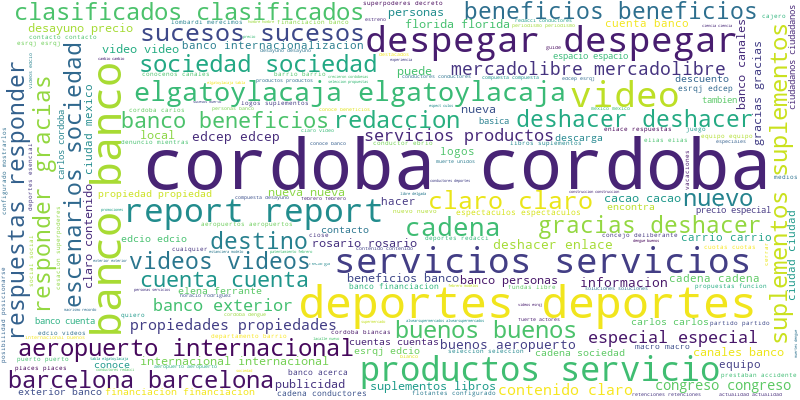

In [111]:
wc = create_wordCloud_from_dataframe(data)
wc.to_image()

In [112]:
# Short words analysis
short_words = list(set([w for w in words if len(w)<=4]))

In [113]:
short_words

['lbl',
 'aca',
 'lock',
 'yzq',
 'cuya',
 'peor',
 'soci',
 'lar',
 'cad',
 'deb',
 'fun',
 'hace',
 'logo',
 'den',
 'unas',
 'espa',
 'lido',
 'dead',
 'lomo',
 'cast',
 'clos',
 'ocio',
 'cab',
 'lot',
 'dede',
 'loic',
 'taco',
 'cano',
 'deal',
 'def',
 'uci',
 'logr',
 'abri',
 'buen',
 'log',
 'lote',
 'mica',
 'edec',
 'guez',
 'edc',
 'unm',
 'eros',
 'uso',
 'cdcb',
 'nico',
 'lida',
 'dej',
 'loca',
 'can',
 'parr',
 'dec',
 'lord',
 'cdc',
 'abre',
 'pue',
 'cam',
 'lost',
 'lon',
 'cosa',
 'lof',
 'lead',
 'acto',
 'loc',
 'edac',
 'reco',
 'icid',
 'debo',
 'debi',
 'ecas',
 'cio',
 'cien',
 'ladr',
 'camp',
 'entr',
 'exj',
 'casa',
 'uelo',
 'usd',
 'qued',
 'dca',
 'abr',
 'fuz',
 'edad',
 'cia',
 'fcde',
 'eae',
 'caja',
 'ebca',
 'fcab',
 'lcd',
 'fuel',
 'saco',
 'epof',
 'cana',
 'dcb',
 'qlo',
 'cis',
 'bici',
 'cero',
 'casi',
 'uefa',
 'cami',
 'ded',
 'peso',
 'cfu',
 'eroq',
 'cpoe',
 'dea',
 'xico',
 'lado',
 'ucgo',
 'dejo',
 'sued',
 'loco',
 'reno',
 'cas

In [114]:
# Update dataframe to exclude meaningless short words
for idx, row in data.iterrows():
    stemmer = Stemmer()
    stemmer.tokenize(row['content'])
    filtered_tokens = ' '.join([token for token in stemmer.tokens if token not in short_words])
    data.at[idx,'content'] = filtered_tokens    

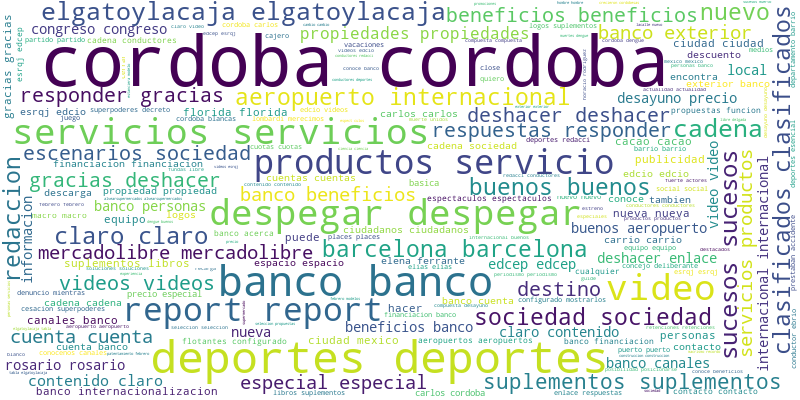

In [115]:
wc = create_wordCloud_from_dataframe(data)
wc.to_image()

In [116]:
# Update dataframe to include one form of each word (stemming + filtering)
# The stemming is done per document in order to lose the contextual meaning as little as possible
"""for idx, row in data.iterrows():
    spanishstemmer = SnowballStemmer('spanish')
    st__ = Stemmer()
    ex_row = row['content']
    st__.tokenize(ex_row)
    mapping = st__.get_stemming_mapList()
    stemmed_freqs, _  = st__.stemmed_frequencies(mapping)
    new_content = list()
    for word in st__.tokens:
        word_stem = spanishstemmer.stem(word)
        if word_stem in stemmed_freqs.keys():
            new_content.append(stemmed_freqs[word_stem][0])
    data.at[idx,'content'] = ' '.join(new_content)
"""

In [119]:
data.to_csv('../data/processed/processed_dataset.csv')